# Overview
Use this notebook to convert an OCT image you have to a virtual H&E image for evaluation.

To get started,
[open this notebook in colab](https://colab.research.google.com/github/WinetraubLab/zero_shot_segmentation/blob/main/testing_sam.ipynb)
 and run.


# inputs

Assumptions:

oct scan x/z rates:
*   microns per pixel z = 1
*   microns per pixel x = 1

pix2pix input sizes:
*   virtual histology input width = 256
*   virtual histology input height = 256

pix2pix input x/z rates:
*   microns per pixel z = 1
*   microns per pixel x = 2

In [1]:
# Pre-processed dataset
preprocessed_dataset_path = "/content/drive/Shareddrives/Yolab - Current Projects/_Datasets/2020-11-10 10x OCT2Hist Model (Paper V2)/Results/TestSet/"

# Define input images
preprocessed_oct_image_paths = [
 (preprocessed_dataset_path + "LE-03-Slide04_Section01_yp0_patch01_real_A.png"), # Used in Paper Figure 3.b
 (preprocessed_dataset_path + "LG-19-Slide04_Section02_yp0_patch01_real_A.png"), # Used in Paper Figure 3.c
 (preprocessed_dataset_path + "LF-01-Slide04_Section02_yp0_patch01_real_A.png"), # Used in Paper Figure 3.d
 (preprocessed_dataset_path + "LG-44-Slide05_Section03_yp0_patch01_real_A.png"), # Used in Paper Figure 3.e
]
preprocessed_oct_image_paths = [s.replace("_real_A", "_fake_B") for s in preprocessed_oct_image_paths]
print(preprocessed_oct_image_paths)

['/content/drive/Shareddrives/Yolab - Current Projects/_Datasets/2020-11-10 10x OCT2Hist Model (Paper V2)/Results/TestSet/LE-03-Slide04_Section01_yp0_patch01_fake_B.png', '/content/drive/Shareddrives/Yolab - Current Projects/_Datasets/2020-11-10 10x OCT2Hist Model (Paper V2)/Results/TestSet/LG-19-Slide04_Section02_yp0_patch01_fake_B.png', '/content/drive/Shareddrives/Yolab - Current Projects/_Datasets/2020-11-10 10x OCT2Hist Model (Paper V2)/Results/TestSet/LF-01-Slide04_Section02_yp0_patch01_fake_B.png', '/content/drive/Shareddrives/Yolab - Current Projects/_Datasets/2020-11-10 10x OCT2Hist Model (Paper V2)/Results/TestSet/LG-44-Slide05_Section03_yp0_patch01_fake_B.png']


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
#segment anything (sam)
using_colab = True
visualize_sam_outputs = True

#sam algorithm input parameters
points_per_side=32
pred_iou_thresh=0.90
stability_score_thresh=0.95
crop_n_layers=1
crop_n_points_downscale_factor=2
min_mask_region_area=3000

#sam model type and weights checkpoint
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

In [4]:
FIG_SIZE = (5,5)

In [5]:
#rf - roboflow dataset related params
rf_api_key="R04BinsZcBZ6PsfKR2fP"
rf_workspace="yolab-kmmfx"
rf_project = "connect_from_colab"
rf_dataset = "png-mask-semantic"

#Zero shot pipeline

In [6]:
# Path to an OCT image to convert
oct_input_image_path = preprocessed_oct_image_paths[0]



In [42]:
oct_input_image_path

'/content/drive/Shareddrives/Yolab - Current Projects/_Datasets/2020-11-10 10x OCT2Hist Model (Paper V2)/Results/TestSet/LE-03-Slide04_Section01_yp0_patch01_fake_B.png'

In [7]:
%pip install dataclasses-json
%pip install supervision
from IPython.display import clear_output
clear_output()

#run sam on virtual histology

## Environment Set-up

In [8]:
!git clone --recurse-submodules https://github.com/WinetraubLab/zero_shot_segmentation.git


Cloning into 'zero_shot_segmentation'...
remote: Enumerating objects: 144, done.
remote: Counting objects: 100% (144/144), done.
remote: Compressing objects: 100% (125/125), done.
remote: Total 144 (delta 59), reused 75 (delta 18), pack-reused 0
Receiving objects: 100% (144/144), 12.30 MiB | 23.07 MiB/s, done.
Resolving deltas: 100% (59/59), done.


In [9]:
!git clone --recurse-submodules https://github.com/WinetraubLab/OCT2Hist-ModelInference


Cloning into 'OCT2Hist-ModelInference'...
remote: Enumerating objects: 651, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (146/146), done.
remote: Total 651 (delta 80), reused 3 (delta 1), pack-reused 504
Receiving objects: 100% (651/651), 22.64 MiB | 18.64 MiB/s, done.
Resolving deltas: 100% (337/337), done.
Submodule 'pytorch-CycleGAN-and-pix2pix' (https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix) registered for path 'pytorch-CycleGAN-and-pix2pix'
Cloning into '/content/OCT2Hist-ModelInference/pytorch-CycleGAN-and-pix2pix'...
remote: Enumerating objects: 2513, done.        
remote: Total 2513 (delta 0), reused 0 (delta 0), pack-reused 2513        
Receiving objects: 100% (2513/2513), 8.20 MiB | 19.56 MiB/s, done.
Resolving deltas: 100% (1575/1575), done.
Submodule path 'pytorch-CycleGAN-and-pix2pix': checked out '9f8f61e5a375c2e01c5187d093ce9c2409f409b0'


In [10]:
!pip install torch
!pip install torchvision
import torch
import torchvision

In [12]:
%run /content/zero_shot_segmentation/setup_roboflow_and_sam.ipynb
from IPython.display import clear_output
clear_output()

To generate masks, just run `generate` on an image.

In [13]:
import cv2

input = cv2.imread(oct_input_image_path)

In [14]:
masks = mask_generator.generate(input)

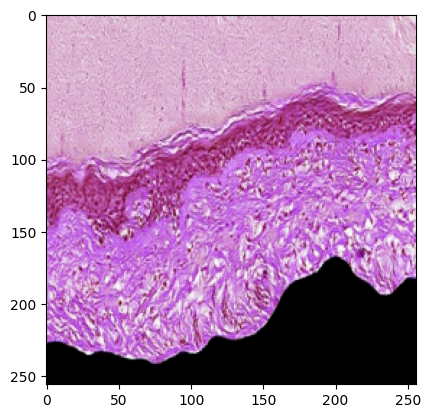

In [15]:
sys.path.append('/content/OCT2Hist-ModelInference')
from utils.show_images import showImg
showImg(input)


Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

Show all the masks overlayed on the image.

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:[link text](https://)


#project on oct

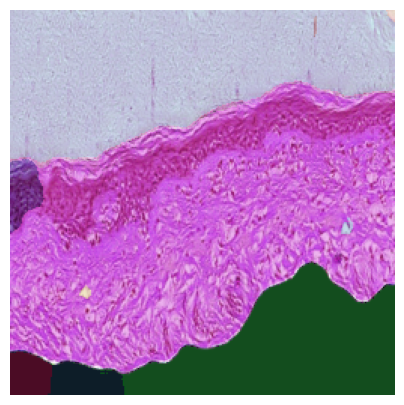

In [17]:
visualize_masks_on_img(input, masks, FIG_SIZE)

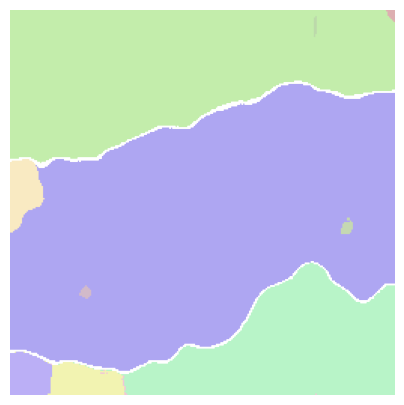

In [18]:
white_image = np.ones_like(input) * 255
visualize_masks_on_img(white_image, masks, FIG_SIZE)

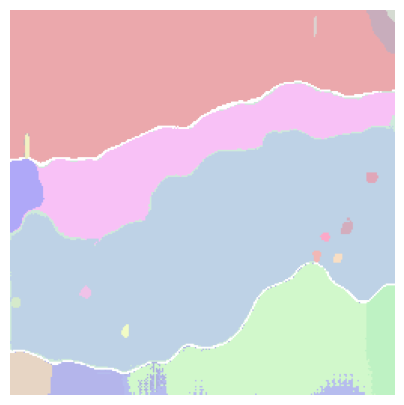

In [24]:
mask_generator.stability_score_thresh=0.1
masks2 = mask_generator.generate(input)
visualize_masks_on_img(white_image, masks2, FIG_SIZE)

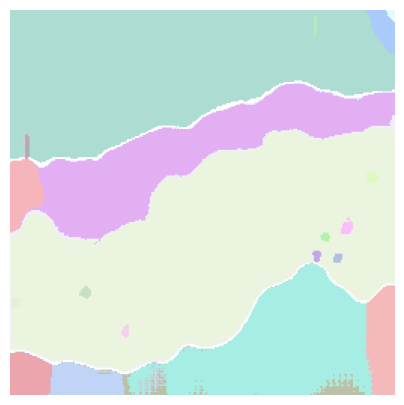

In [25]:
mask_generator.stability_score_thresh=0.01
masks2 = mask_generator.generate(input)
visualize_masks_on_img(white_image, masks2, FIG_SIZE)

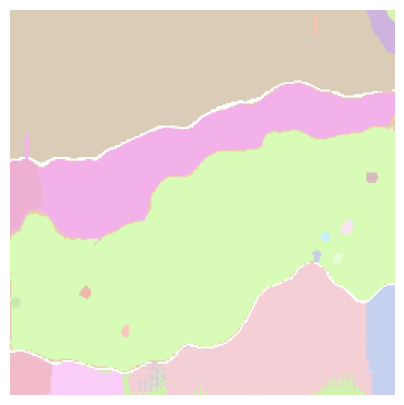

In [26]:
mask_generator.stability_score_thresh=0
masks2 = mask_generator.generate(input)
visualize_masks_on_img(white_image, masks2, FIG_SIZE)

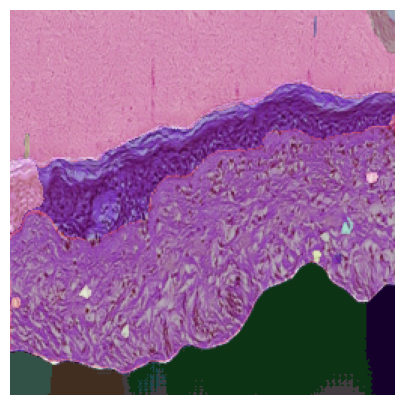

In [27]:
visualize_masks_on_img(input, masks2, FIG_SIZE)

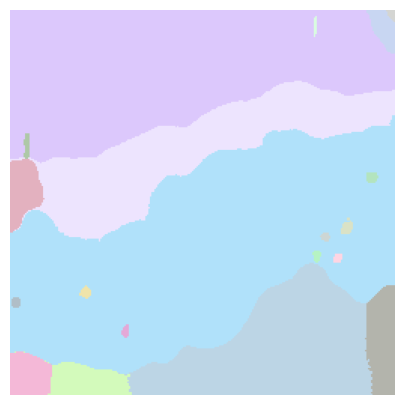

In [41]:
mask_generator.box_nms_thresh=0.5
mask_generator.min_mask_region_area = 35000
masks2 = mask_generator.generate(input)
visualize_masks_on_img(white_image, masks2, FIG_SIZE)